# Overview

Here we lay out an method to classify respiratory disease using a convolutional neural network. Image features are combined together to make the input. Because all these features need to be extracted it takes about 40 mins to run (make yourself a coffee or something). This method achieves an accuracy of 95% and a loss of around 0.2.

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

# Parsing the Dataset

In [ ]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path   

In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_wav_files():
  audio_path = '/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [ ]:
def diagnosis_data():
  diagnosis = pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')
  
  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}  
  diagnosis_list = []
  
  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]     

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
    c+=1  

  return diagnosis_list

# Feature Extraction

In [ ]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))  
 
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis]) 
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

# Preprocessing

In [ ]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)  

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

In [ ]:
start = timer()

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

print('Time taken: ', (timer() - start))

0
1
2
3


/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
30

# Convolutional Neural Network 

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 7s 1s/step - loss: 5.9745 - accuracy: 0.6426 - val_loss: 2.4655 - val_accuracy: 0.7228
Epoch 2/70
4/4 [==============================] - 6s 1s/step - loss: 3.2791 - accuracy: 0.6548 - val_loss: 2.5331 - val_accuracy: 0.8967
Epoch 3/70
4/4 [==============================] - 4s 1s/step - loss: 4.1981 - accuracy: 0.8568 - val_loss: 1.8096 - val_accuracy: 0.8967
Epoch 4/70
4/4 [==============================] - 5s 1s/step - loss: 2.5785 - accuracy: 0.8554 - val_loss: 1.0139 - val_accuracy: 0.8967
Epoch 5/70
4/4 [==============================] - 6s 1s/step - loss: 1.4032 - accuracy: 0.7940 - val_loss: 0.6580 - val_accuracy: 0.8967
Epoch 6/70
4/4 [==============================] - 4s 1s/step - loss: 0.7835 - accuracy: 0.8568 - val_loss: 0.4547 - val_accuracy: 0.8967
Epoch 7/70
4/4 [==============================] - 5s 1s/step - loss: 0.5999 - accuracy: 0.8431 - val_loss: 0.4213 - val_accuracy: 0.8967
Epoch 8/70
4/4 [=========================

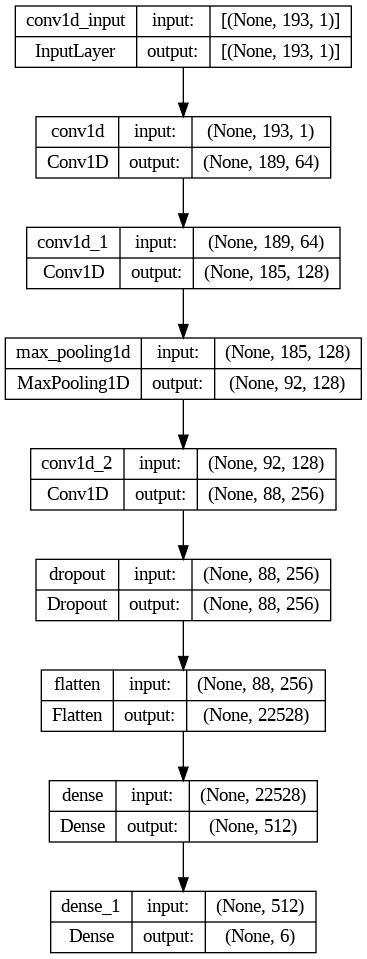

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

# Evaluation

Accuracy: 95%
Loss: 0.1767



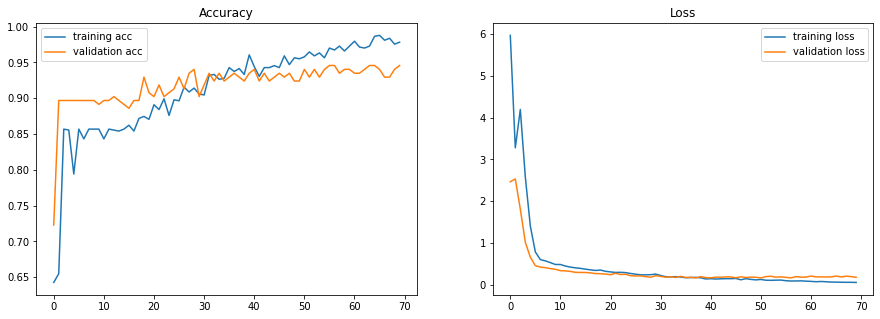

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

6/6 [==============================] - 0s 43ms/step
                precision    recall  f1-score   support

          COPD       0.98      0.99      0.98       165
       Healthy       0.60      0.43      0.50         7
          URTI       0.50      0.50      0.50         4
Bronchiectasis       1.00      0.75      0.86         4
     Pneumoina       0.60      1.00      0.75         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.95       184
     macro avg       0.61      0.61      0.60       184
  weighted avg       0.95      0.95      0.94       184



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

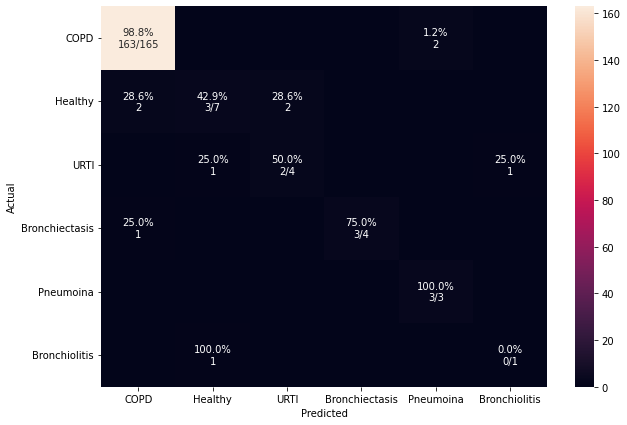

In [ ]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')